<a href="https://colab.research.google.com/github/dilashapradhan/Mine/blob/master/worksheet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
train_dir = '/content/drive/MyDrive/AI/FruitinAmazon/FruitinAmazon/train'
class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

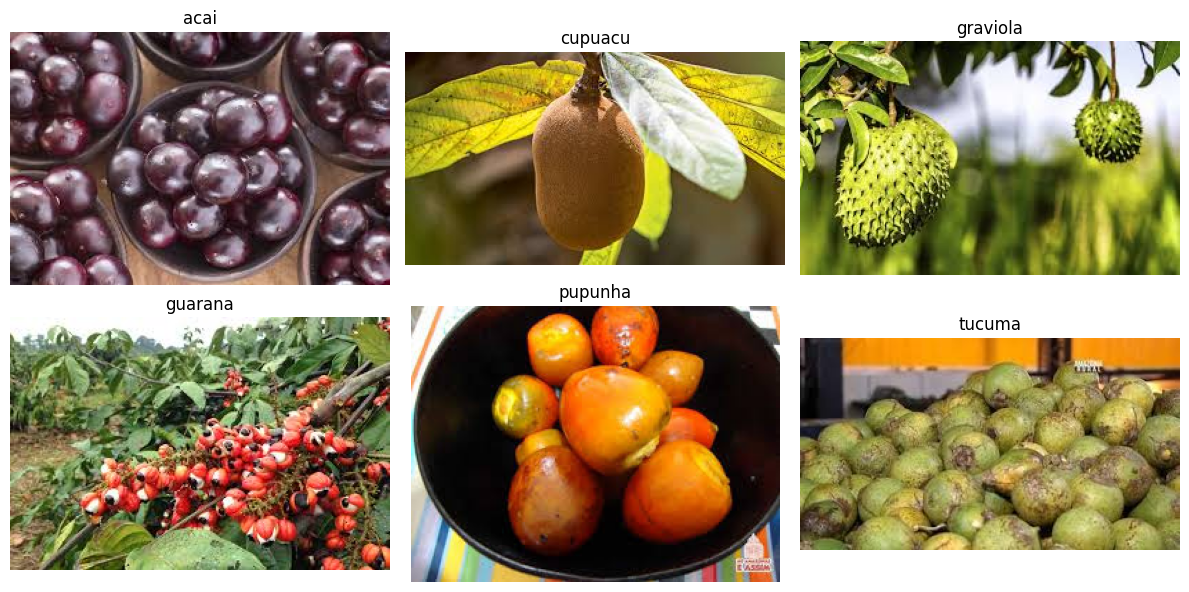

In [9]:
class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
image_paths = []
for class_dir in class_dirs:
    class_path = os.path.join(train_dir, class_dir)
    images = os.listdir(class_path)
    if images:
        image_paths.append(os.path.join(class_path, random.choice(images)))
num_classes = len(image_paths)
fig, axes = plt.subplots(nrows=2, ncols=(num_classes + 1) // 2, figsize=(12, 6))

for ax, img_path, label in zip(axes.flatten(), image_paths, class_dirs):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [10]:
from PIL import Image
corrupted_images = []
for class_dir in class_dirs:
    class_path = os.path.join(train_dir, class_dir)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        try:
            with Image.open(img_path) as img:
                img.verify()

        except (IOError, SyntaxError):
            corrupted_images.append(img_path)
            os.remove(img_path)
            print(f"Removed corrupted image: {img_path}")
if not corrupted_images:
    print("No Corrupted Images Found.")
else:
    print(f"Total corrupted images removed: {len(corrupted_images)}")

No Corrupted Images Found.


In [11]:
def load_and_preprocess_data(train_dir, img_height, img_width, batch_size, validation_split):
    rescale = tf.keras.layers.Rescaling(1./255)

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='int',
        image_size=(img_height, img_width),
        interpolation='nearest',
        batch_size=batch_size,
        shuffle=True,
        validation_split=validation_split,
        subset='training',
        seed=123
    )

    train_ds = train_ds.map(lambda x, y: (rescale(x), y))

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='int',
        image_size=(img_height, img_width),
        interpolation='nearest',
        batch_size=batch_size,
        shuffle=False,
        validation_split=validation_split,
        subset='validation',
        seed=123
    )

    val_ds = val_ds.map(lambda x, y: (rescale(x), y))

    return train_ds, val_ds
img_height = 128
img_width = 128
batch_size = 32
validation_split = 0.2
train_ds, val_ds = load_and_preprocess_data(train_dir, img_height, img_width, batch_size, validation_split)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [13]:
num_classes = 6
model = keras.Sequential([
    # Convolutional Layer 1
    layers.Conv2D(32, (3, 3), padding="same", strides=1, activation="relu", input_shape=(128, 128, 3)),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),

    # Convolutional Layer 2
    layers.Conv2D(32, (3, 3), padding="same", strides=1, activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),

    # Flatten Layer
    layers.Flatten(),

    # Fully Connected Layers
    layers.Dense(64, activation="relu"),
    layers.Dense(128, activation="relu"),

    # Output Layer
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras import layers, models

def create_cnn_model(num_classes, input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

num_classes = len(os.listdir(train_dir))
input_shape = (img_height, img_width, 3)
model = create_cnn_model(num_classes, input_shape)


In [15]:
def create_cnn_model(num_classes, input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model
num_classes = len(os.listdir(train_dir))
input_shape = (img_height, img_width, 3)
model = create_cnn_model(num_classes, input_shape)

In [16]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=10, restore_best_weights=True)
]
history = model.fit(train_ds, epochs=250, validation_data=val_ds, callbacks=callbacks)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 885ms/step - accuracy: 0.1554 - loss: 3.1884 - val_accuracy: 0.8333 - val_loss: 1.1282
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 427ms/step - accuracy: 0.1923 - loss: 3.1002 - val_accuracy: 0.1111 - val_loss: 1.7035
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - accuracy: 0.4271 - loss: 1.5937 - val_accuracy: 0.3889 - val_loss: 1.2985
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 587ms/step - accuracy: 0.5130 - loss: 1.4211 - val_accuracy: 0.7778 - val_loss: 1.0821
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 557ms/step - accuracy: 0.4332 - loss: 1.2663 - val_accuracy: 0.8333 - val_loss: 0.8110
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 910ms/step - accuracy: 0.7322 - loss: 0.9425 - val_accuracy: 0.8333 - val_loss: 0.7954
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 542ms/step - accuracy: 0.8355 - loss: 0.6977 - val_accuracy: 0.8333 - val_loss: 0.6859
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 546ms/step - accuracy: 0.9232 - loss: 0.4915 - val_accuracy: 0.8333 - v

In [18]:
rescale = tf.keras.layers.Rescaling(1./255)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/AI/FruitinAmazon/FruitinAmazon/test',
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False
)
test_ds = test_ds.map(lambda x, y: (rescale(x), y))
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")

Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8333 - loss: 0.6727
Test accuracy: 0.8333


In [ ]:
history = model.fit(
    train_ds,  # Training dataset (defined in Task 2)
    validation_data=val_ds,  # Validation dataset (defined in Task 2)
    epochs=250,  # Number of epochs
    batch_size=16,  # Batch size
    callbacks=callbacks,  # Callbacks for checkpointing and early stopping
    verbose=1  # Show progress during training
)
print("Training finished.")

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 514ms/step - accuracy: 1.0000 - loss: 0.0303 - val_accuracy: 0.8889 - val_loss: 0.3185
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 823ms/step - accuracy: 1.0000 - loss: 0.0236 - val_accuracy: 0.8333 - val_loss: 0.3452
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 587ms/step - accuracy: 1.0000 - loss: 0.0152 - val_accuracy: 0.8333 - val_loss: 0.3982
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 561ms/step - accuracy: 1.0000 - loss: 0.0101 - val_accuracy: 0.8333 - val_loss: 0.3995
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 541ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.8333 - val_loss: 0.3729
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 681ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 0.8333 - val_loss: 0.3508
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 839ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.8333 - val_loss: 0.3336
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 679ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.8333 - v

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = '/content/drive/MyDrive/AI/FruitinAmazon/FruitinAmazon/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='sparse',
    shuffle=False
)

Found 30 images belonging to 6 classes.


In [22]:
test_loss, test_accuracy = model.evaluate(test_ds, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 - 0s - 191ms/step - accuracy: 0.8333 - loss: 0.6933
Test Loss: 0.6932684779167175
Test Accuracy: 0.8333333134651184


In [23]:
rescale = tf.keras.layers.Rescaling(1./255)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/AI/FruitinAmazon/FruitinAmazon/test',
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False
)
test_ds = test_ds.map(lambda x, y: (rescale(x), y))
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")

Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.8333 - loss: 0.6727
Test accuracy: 0.8333


In [24]:
test_loss, test_accuracy = model.evaluate(test_ds, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 - 0s - 255ms/step - accuracy: 0.8333 - loss: 0.6727
Test Loss: 0.6726702451705933
Test Accuracy: 0.8333333134651184
